# 4.3. Summary of results

In this section the results of the various GARCH models that used exogenous regressors are displayed. Both the time-varying models as well as the regular models are shown in this section.

## 4.3.1. Load packages and data

Here, load the packages, data and colors for the main analysis and for the construction of plots, also define export locations

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import os, sys
import itertools
from datetime import datetime
from scipy.stats import chi2
from scipy.stats import norm

# Load data that returns tweets
sys.path.insert(0, os.path.abspath(r'C:\Users\Jonas\PycharmProjects\TwitterSentimentGARCH2021\Code\GARCH model'))
from garch_models import ArmaApARCHX, ArmaXapARCH, ArmaApArchXGarch, ExogGarch
sys.path.insert(0, os.path.abspath(r'C:\Users\Jonas\PycharmProjects\TwitterSentimentGARCH2021\Code\GARCH model\tvGARCH models'))
from tv_garch_models import tvArmaApARCHX, tvArmaXapARCH, tvArmaApArchXGarch

# Surpress warnings
import warnings
warnings.filterwarnings("ignore")

### 4.3.1.1. Colors for plots

In [2]:
colors = ['seagreen', 'mediumaquamarine', 'steelblue', 'cornflowerblue', 'navy', 'black'] * 3

### 4.3.1.2 Load data

Load company name data and DataFrame per company containing all the sentiment, return and control variable data

In [3]:
# Specify location of data + file name and location of storage
company_loc = r'C:\Users\Jonas\Documents\Data'
file_name_comp = '\company_ticker_list_all.xlsx'

# Access company names DataFrame
df_comp_names = pd.read_excel(company_loc + file_name_comp)

Specify location where all company specific data is stored

In [4]:
# Specify name and location
data_loc = r'C:\Users\Jonas\Documents\Data\Total_data'

Specify location where to store results

In [5]:
# Specify location where daily sentiment scores must be stored
store_loc = r'C:\Users\Jonas\Documents\Data\Results'

Hard code the numerous types of columns used in this section

In [6]:
# Define possible exogenous columns
control_cols = ['VIX', 'TEDRATE']
sent_cols = ['sentiment', 'n_tweets', 'n_interactions']

exog_cols = sent_cols

# Define data on which to impose GARCH structure, and provide column names
x_garch_cols = [f'sigma2_{col}' for col in sent_cols]

# Define proper model names used for plots
model_names = ['ARMA-X-apARCH', 'ARMA-apXapARCH', 'ARMA-apGARCHX']

# Define tv smoothing operator h
h = 25

Define helper function that can calculate the quasi log likelihood

In [7]:
def quasi_log_likelihood(sigma2, et):
    # QMLE from Franq and Thieu
    lls = np.log(sigma2) + ((et ** 2) / sigma2)

    # Calculate Quasi Maximum Likelihood
    ll = np.nan_to_num(lls).sum()

    return -ll

def likelihoodratio(ll_1, ll_2):
    return - 2 * (ll_1 - ll_2)

def bic(n, T, LL):
    return n * np.log(T) - (2 * LL * T)

import colorsys

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

import matplotlib
import seaborn as sns

color = matplotlib.colors.ColorConverter.to_rgb("navy")
rgbs = [scale_lightness(color, scale) for scale in [0, .5, 1, 1.5, 2]]
navy_color = rgbs[1]

## 4.3.2. Summary of exogenous GARCH process

This section will shown the descriptive statistics and parameters of the Exogenous GARCH process.

In [86]:
# For every company in the dataset, read the data and construct the appropriate model
for i, company in enumerate(df_comp_names['Company']):   
    # Read data
    data_name = f'\\total data {company}.csv' 
    
    # Get df_total, with sigma2 in there
    df_total = pd.read_csv(data_loc + data_name)   
    
    # Read parameters of exogenous GARCH process
    df_xgarch_params = pd.read_csv(data_loc + f'\\exogenous garch data\\xgarch_params {company}.csv')
    
    # Split df_xgarch_params into three subdataframes
    df_params1 = df_xgarch_params.iloc[:, 1:5]
    df_params2 = df_xgarch_params.iloc[:, 5:9]
    df_params3 = df_xgarch_params.iloc[:, 9:13]
    
    # Create summary statistics
    ds_sentiment1 = [[['mean', np.mean(df_total[col])], 
                     ['std',   np.std(df_total[col])], 
                     ['n_obs', len(df_total[col])],
                     ['min',   np.min(df_total[col])],  
                     ['max',   np.max(df_total[col])],
                     ['QLL', quasi_log_likelihood(df_total[f'sigma2_{col}'], df_total[f'et_{col}'])]] for col in sent_cols]
    
    ds_sentiment2 = [[[np.mean(df_total[col])], 
                     [np.std(df_total[col])], 
                     [len(df_total[col])],
                     [np.min(df_total[col])],  
                     [np.max(df_total[col])],
                     [quasi_log_likelihood(df_total[f'sigma2_{col}'], df_total[f'et_{col}'])]] for col in sent_cols]
    
    # Compile errors in parentheses
    errors1 = df_params1['errors'].apply(lambda x: '%.1e' % x).apply(lambda x: f' ({x})')
    p = df_params1['t-stat'].apply(lambda x: ''.join(['*' for alpha in [0.1, 0.05, 0.01] if abs(x) >= norm.ppf(1-2*alpha)]))
    
    df_params = pd.DataFrame(columns = ['param names', f'psi_hat_{company}'])
    for j in range(len(df_params1)):
        df_params.loc[len(df_params)] = [df_params1.iloc[j]['param names'], 
                                         df_params1.iloc[j]['psi_hat'].round(3).astype(str) + p[j]]
        df_params.loc[len(df_params)] = [f'error {j}', errors1[j]]
            
    df_params1 = df_params

    
    errors2 = df_params2['errors.1'].apply(lambda x: '%.1e' % x).apply(lambda x: f' ({x})')
    p = df_params2['t-stat.1'].apply(lambda x: ''.join(['*' for alpha in [0.1, 0.05, 0.01] if abs(x) >= norm.ppf(1-alpha)]))
    
    df_params = pd.DataFrame(columns = ['param names', f'psi_hat_{company}'])
    for j in range(len(df_params2)):
        df_params.loc[len(df_params)] = [df_params2.iloc[j]['param names.1'], 
                                         df_params2.iloc[j]['psi_hat.1'].round(3).astype(str) + p[j]]
        df_params.loc[len(df_params)] = [f'error {j}', errors2[j]]
            
    df_params2 = df_params
   
    
    errors3 = df_params3['errors.2'].apply(lambda x: '%.1e' % x).apply(lambda x:  f' ({x})')
    p = df_params3['t-stat.2'].apply(lambda x: ''.join(['*' for alpha in [0.1, 0.05, 0.01] if abs(x) >= norm.ppf(1-alpha)]))
    
    df_params = pd.DataFrame(columns = ['param names', f'psi_hat_{company}'])
    for j in range(len(df_params3)):
        df_params.loc[len(df_params)] = [df_params3.iloc[j]['param names.2'], 
                                         df_params3.iloc[j]['psi_hat.2'].round(3).astype(str) + p[j]]
        df_params.loc[len(df_params)] = [f'error {j}', errors3[j]]
            
    df_params3 = df_params
    
    df_params1 = df_params1.append(pd.DataFrame(ds_sentiment1[0], columns=df_params1.columns)).reset_index(drop=True)
    df_params2 = df_params2.append(pd.DataFrame(ds_sentiment1[1], columns=df_params2.columns)).reset_index(drop=True)
    df_params3 = df_params3.append(pd.DataFrame(ds_sentiment1[2], columns=df_params3.columns)).reset_index(drop=True)

    
    if i == 0:        
        df_psi_hat_1 = df_params1
        df_psi_hat_2 = df_params2
        df_psi_hat_3 = df_params3
    else:
        df_psi_hat_1 = df_psi_hat_1.merge(df_params1[['param names', f'psi_hat_{company}']], 
                                          on='param names', 
                                          how='outer') 

        df_psi_hat_2 = df_psi_hat_2.merge(df_params2[['param names', f'psi_hat_{company}']], 
                                          on='param names', 
                                          how='outer')
    

        df_psi_hat_3 = df_psi_hat_3.merge(df_params3[['param names', f'psi_hat_{company}']], 
                                          on='param names', 
                                          how='outer')
     
    # Save DataFrames to .csv
    df_psi_hat_1.to_csv(data_loc + f'\\parameters\\params exog {sent_cols[0]}.csv')
    df_psi_hat_2.to_csv(data_loc + f'\\parameters\\params exog {sent_cols[1]}.csv')
    df_psi_hat_3.to_csv(data_loc + f'\\parameters\\params exog {sent_cols[2]}.csv')

Make plots of the exogenous processes

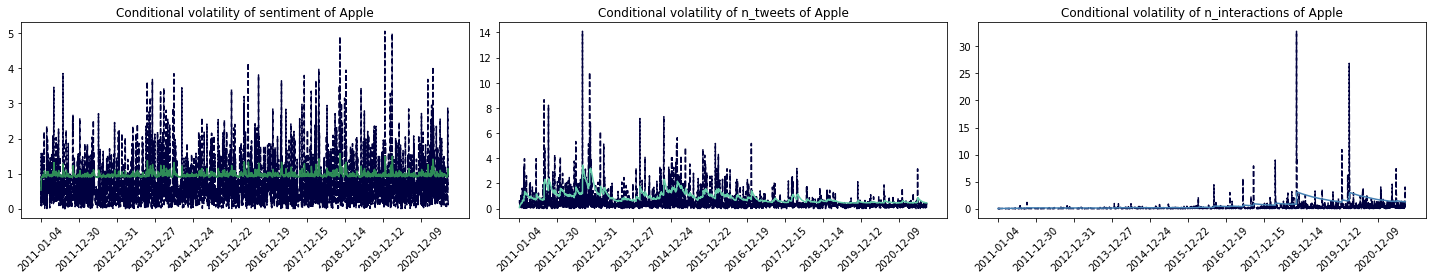

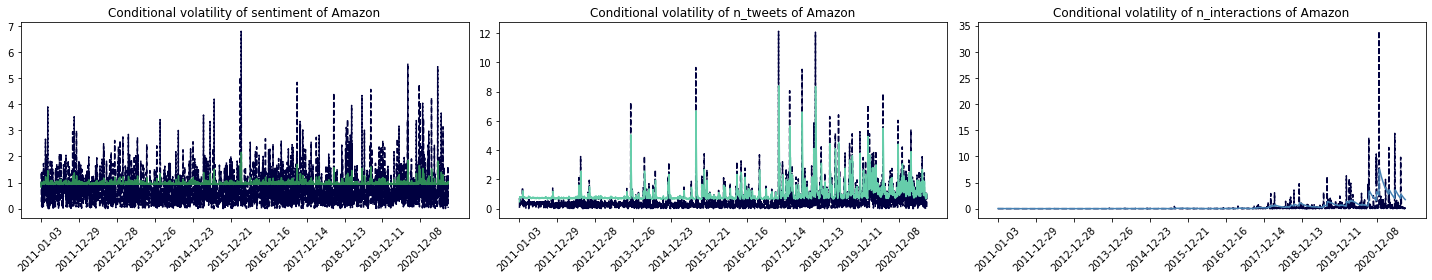

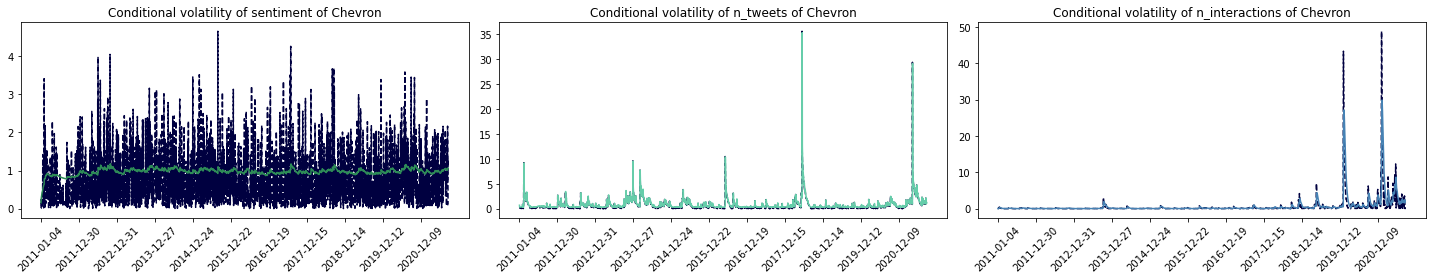

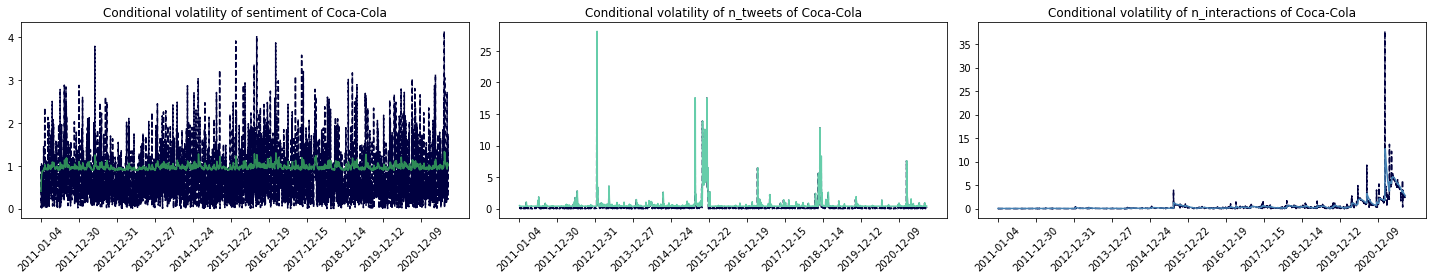

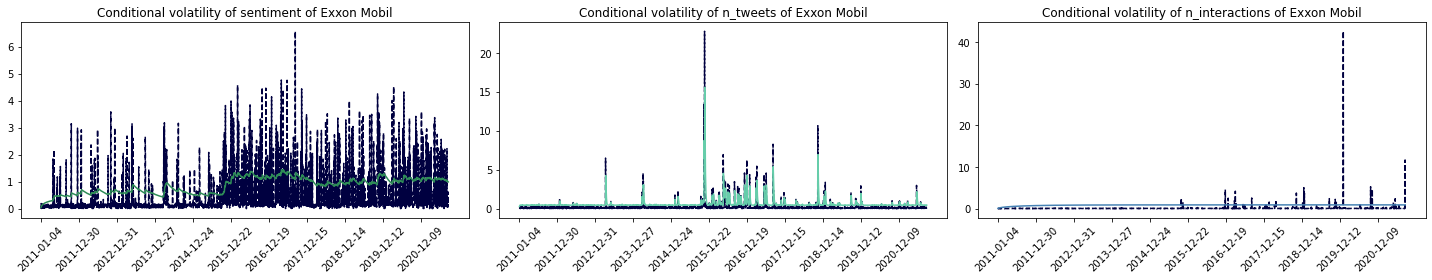

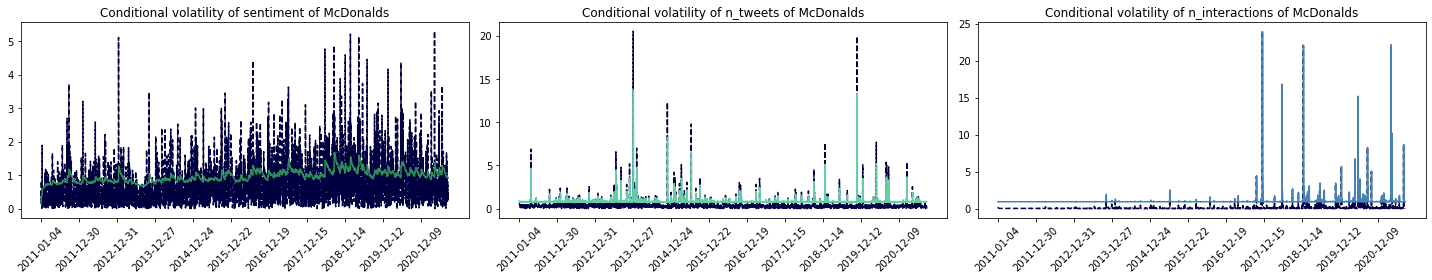

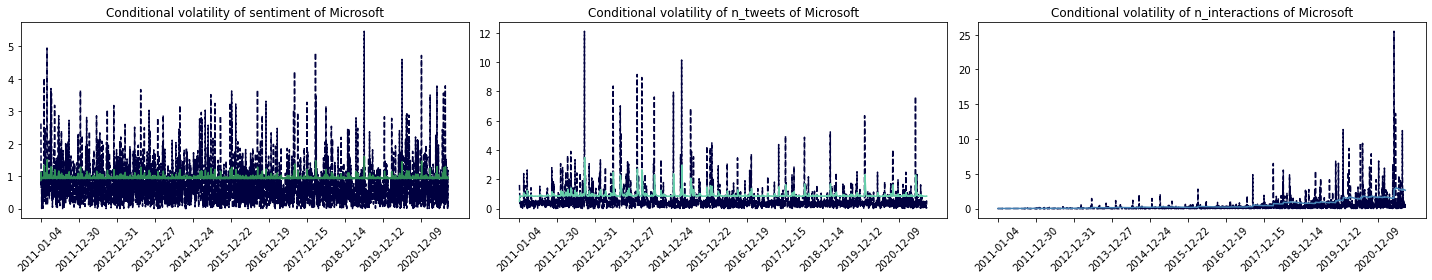

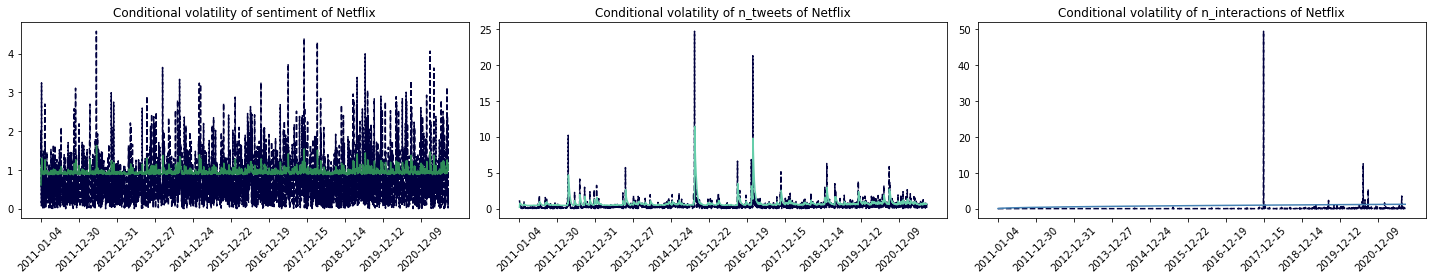

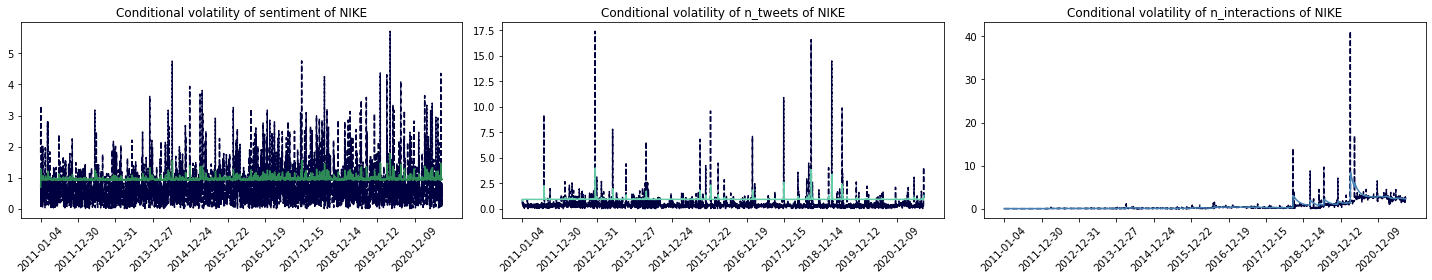

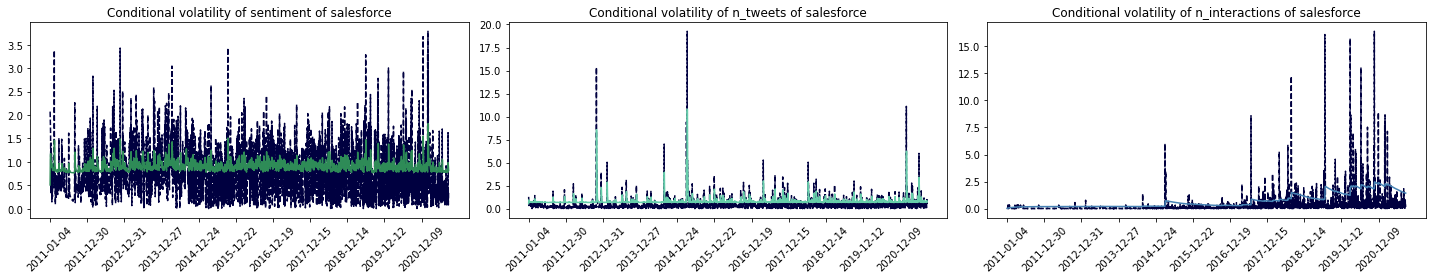

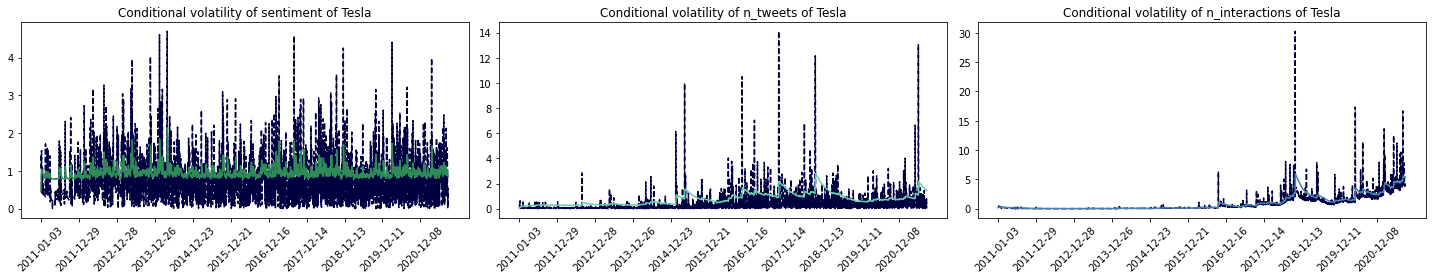

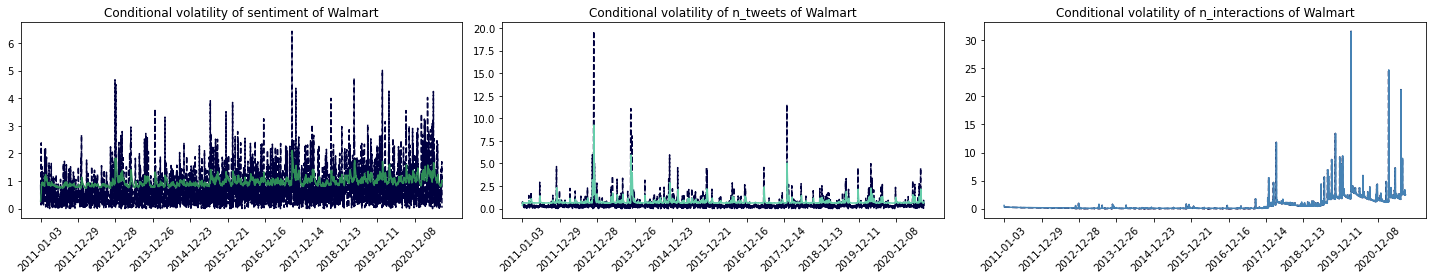

In [24]:
# For every company in the dataset, read the data and construct the appropriate model
for company in df_comp_names['Company']:   
    # Read data
    data_name = f'\\total data {company}.csv' 
    
    # Get df_total
    df_total = pd.read_csv(data_loc + data_name)        
    
    # Construct plots for all sentiment cols
    fig, axs = plt.subplots(figsize = (20,4), nrows = 1, ncols = 3)

    first_date, last_date = df_total.date.iloc[0], df_total.date.iloc[-1]
    n = 250  # keeps every 250th label (around a year)

    for j, col in enumerate(sent_cols):         
        # Append df_total with the sigma2_x variable
        sigma2_x = df_total[f'sigma2_{col}']
        et_x = df_total[f'et_{col}']

        # Plot volatility of sentiment metric
        axs[j].plot(df_total.date, np.sqrt(et_x ** 2), c=navy_color, linestyle='--')
        axs[j].plot(df_total.date, np.sqrt(sigma2_x), c=colors[j])
        
        # Set title and xticklabels
        axs[j].set_xticks(axs[j].get_xticks()[::n])
        axs[j].tick_params(axis='x', labelrotation = 45)
        
        # Check behaviour of the innovations
        #axs[j].hist(et_x / np.sqrt(sigma2_x), bins=50)
        #print(np.mean(et_x / np.sqrt(sigma2_x)), np.std(et_x / np.sqrt(sigma2_x)))

        # Set title and xticklabels
        axs[j].set_title(f'Conditional volatility of {col} of {company}')

        plt.tight_layout()
        
    # Store figures as PNG
    fig.savefig(store_loc + f'\\plots\\plots sigma2 sentiment {company}')

## 4.3.1 Summary of results: plots of volatility processes

Here, calculate and plot the constructed values of the conditional volatility model, by any of the models, including the benchmark and the time-varying model.

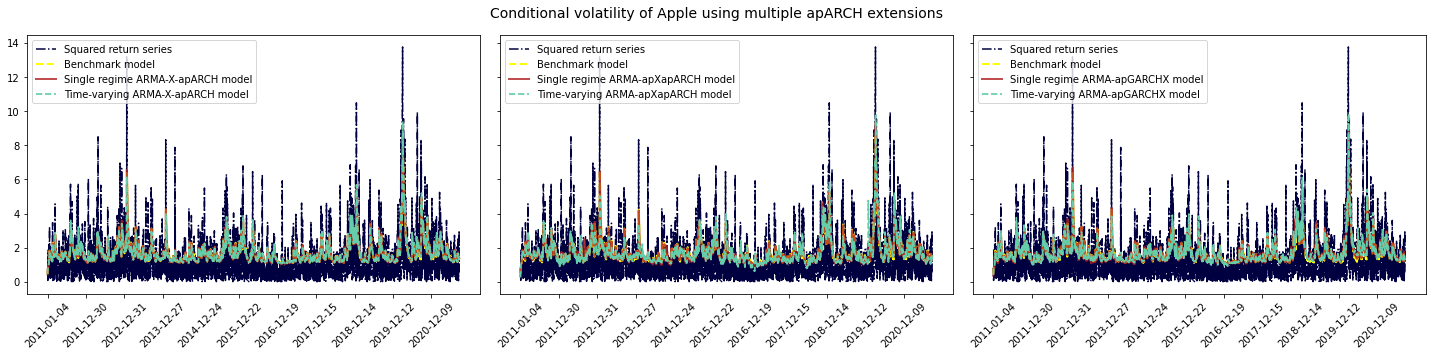

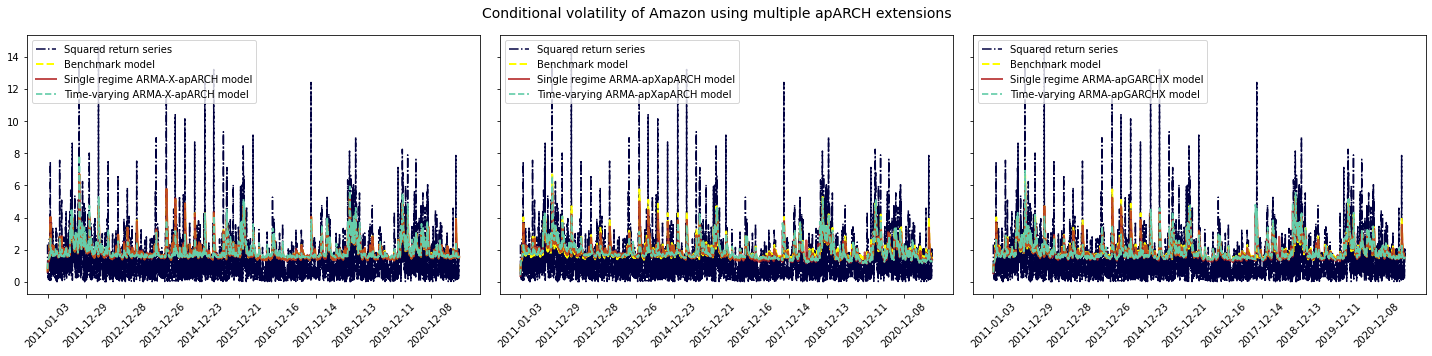

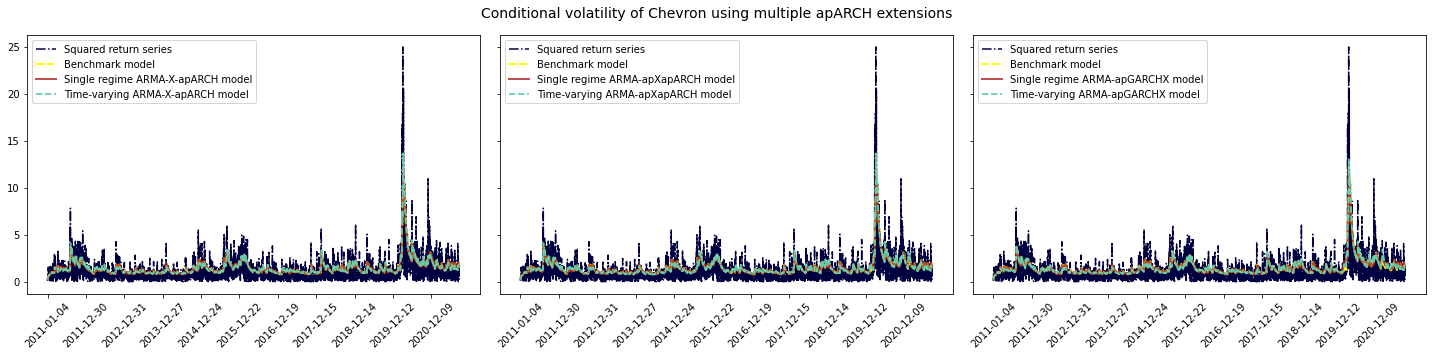

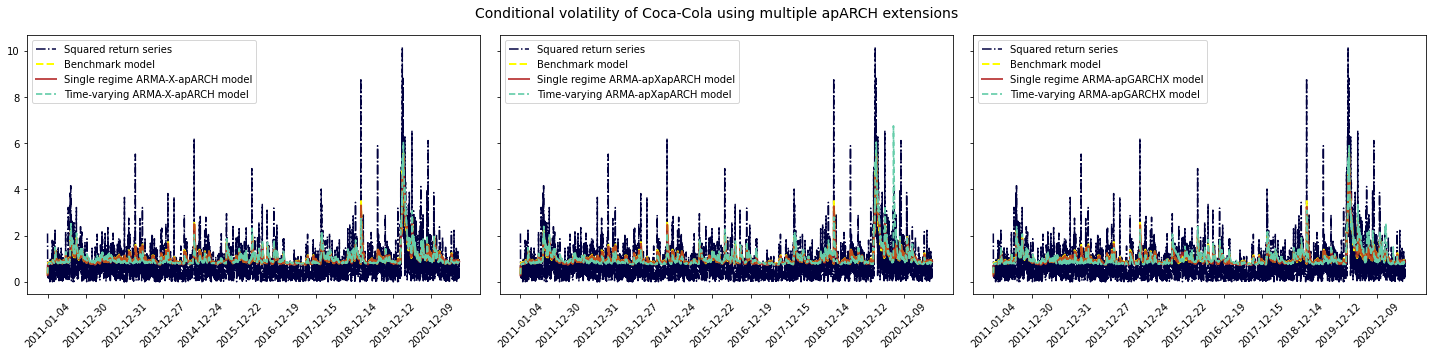

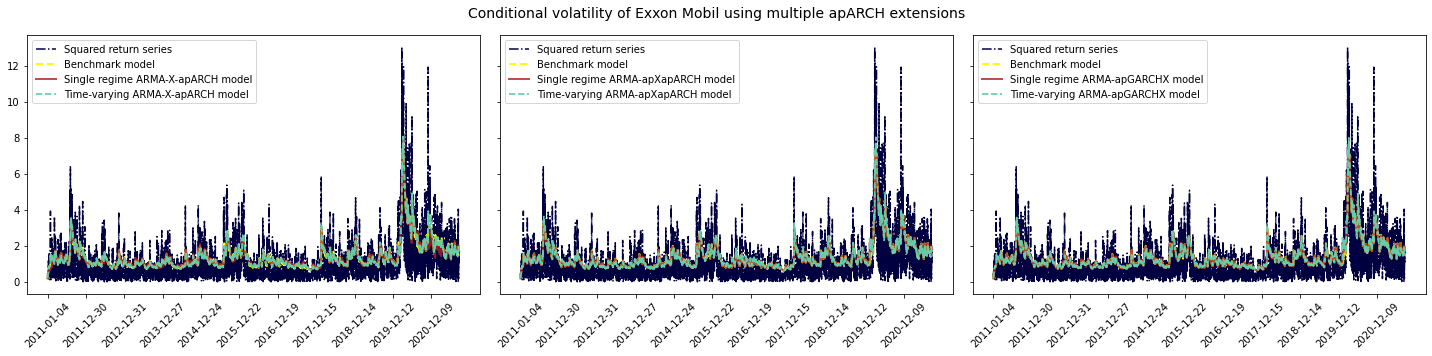

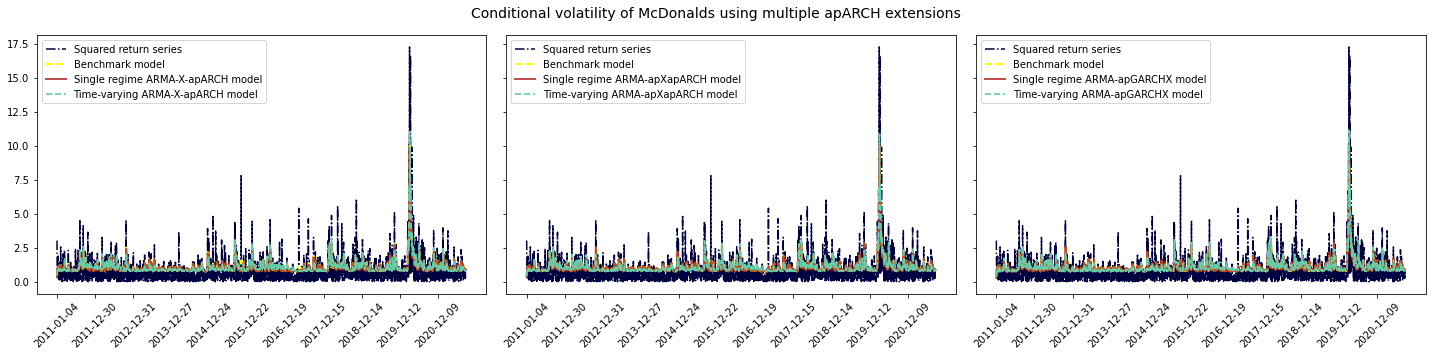

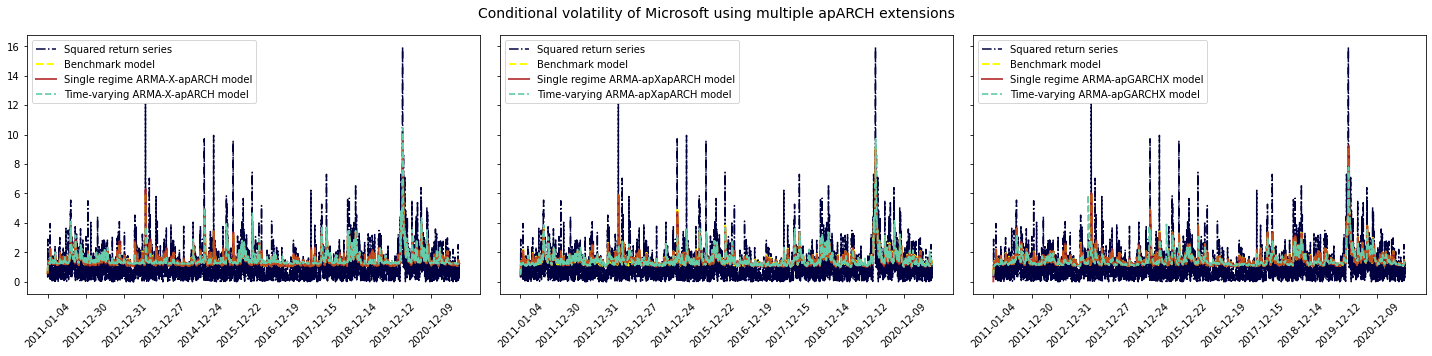

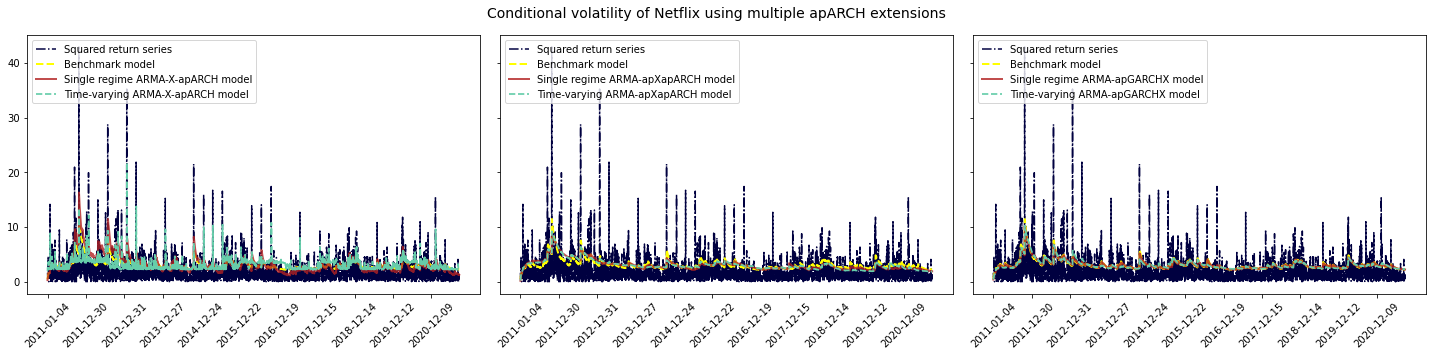

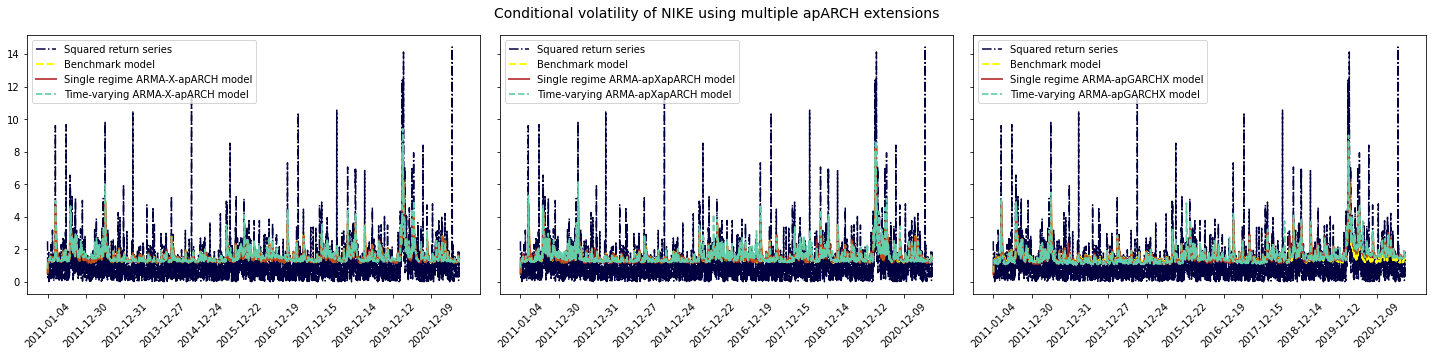

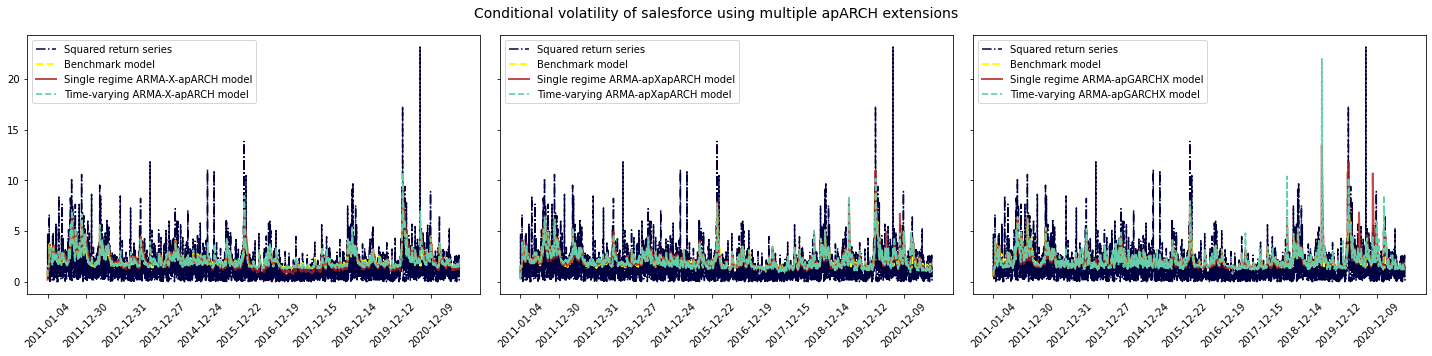

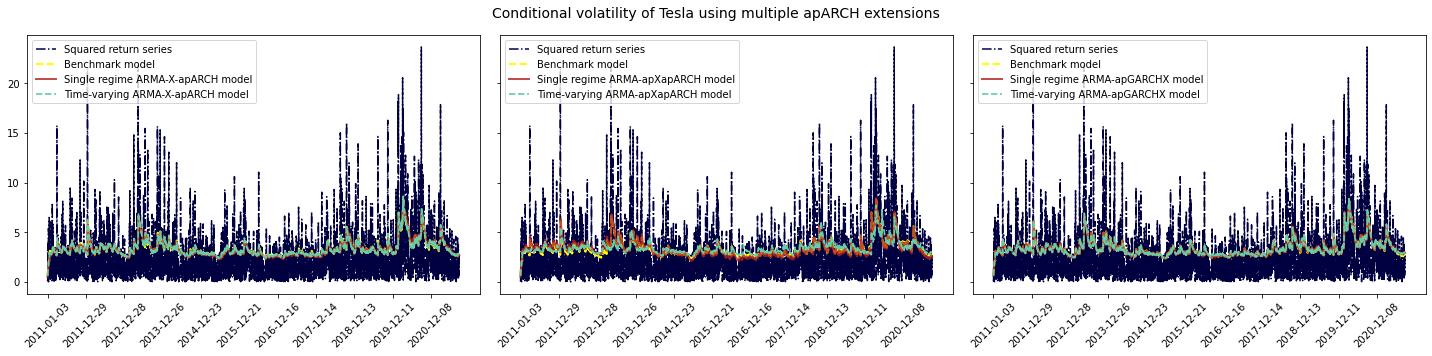

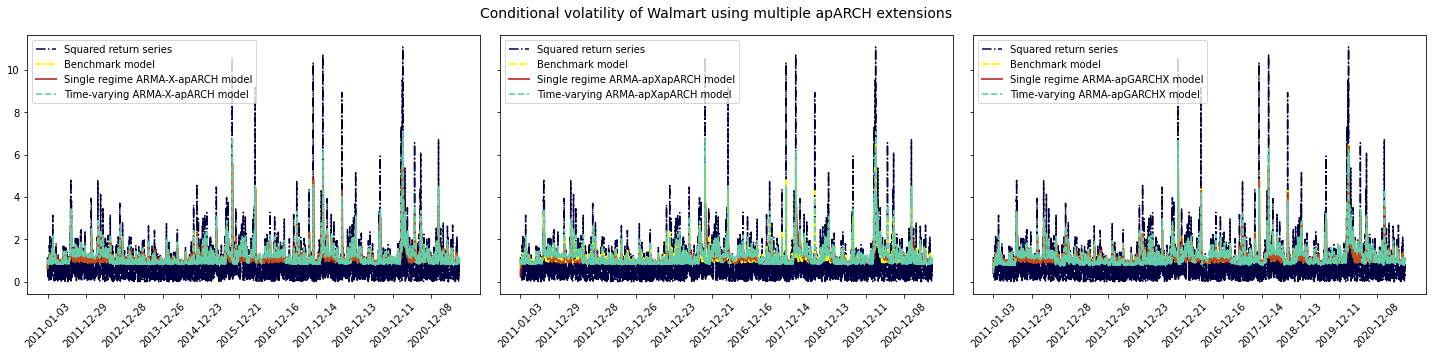

In [15]:
# Find lags specification for each model
df_model_specification = pd.read_csv(data_loc + f'\\lags\\model_params.csv')

# For every company in the dataset, read the data and construct the appropriate model
for company, ticker in zip(df_comp_names['Company'], df_comp_names['Symbol']):    
    # Read data
    data_name = f'\\total data {company}.csv' 
    
    # Get df_total
    df_total = pd.read_csv(data_loc + data_name)
       
    # Drop NaNs
    df_total = df_total.fillna(0)
    
    # Calculate realised volatility
    returns_name = f'//{ticker}.csv'
    df_returns = pd.read_csv(f'C:\\Users\\Jonas\\Documents\\Data\\Returns\\{ticker}.csv')   
    adjusted_range = (1 / (2 * np.sqrt(np.log(2)))) * (df_returns.High[1:] - df_returns.Low[1:]) # Calculate adjusted range
    df_total['real_vol'] = adjusted_range
    
    # Unpack the optimal lags of the ARMA procedure from df_model_specification
    lags_per_model = [literal_eval(x) for x in df_model_specification[company]]
    lags_arma = list(lags_per_model[0])
    exog_lags = list(lags_per_model[3])[:len(exog_cols)]
    x_garch_lags = list(lags_per_model[3])[len(exog_cols):]
    
    ### ---------- SINGLE REGIME SPECIFICATION --------- ###
    
    # Open parameter files
    df_params = pd.read_csv(data_loc + f'\\parameters\\benchmark\\benchmark {company}.csv')
    df_params1 = pd.read_csv(data_loc + f'\\parameters\\model1\\params {company}.csv')
    df_params2 = pd.read_csv(data_loc + f'\\parameters\\model2\\params {company}.csv')
    df_params3 = pd.read_csv(data_loc + f'\\parameters\\model3\\params {company}.csv')
    
    # Calculate sigma2 values for each model
    benchmark = ArmaApARCHX(df_total, 'returns', lags_arma, params=df_params['psi_hat'].tolist())
    
    
    model1 = ArmaXapARCH(df_total, 'returns', lags_arma, exog_cols, list(lags_per_model[1]), 
                         params = df_params1['psi_hat'].tolist())
    
    model2 = ArmaApARCHX(df_total, 'returns', lags_arma, exog_cols, list(lags_per_model[2]), 
                         params = df_params2['psi_hat'].tolist())
       
    model3 = ArmaApArchXGarch(df_total, 'returns', lags_arma, exog_cols, exog_lags, 
                              params = df_params3['psi_hat'].tolist(),
                              xgarch_cols=x_garch_cols, lag_exog_sigma=x_garch_lags)
    
    sigma2, et = benchmark.conditional_volatility()
    sigma2_1, et_1 = model1.conditional_volatility()
    sigma2_2, et_2 = model2.conditional_volatility()
    sigma2_3, et_3 = model3.conditional_volatility()
    
    vars_, ets = [sigma2_1, sigma2_2, sigma2_3], [et_1, et_2, et_3]
     
    ### ---------- TIME VARYING SPECIFICATION --------- ###
    
    # Open parameter files
    df_tv_params = pd.read_csv(data_loc + f'\\parameters\\benchmark\\tv params {company}.csv')
    df_tv_params1 = pd.read_csv(data_loc + f'\\parameters\\model1\\tv params {company}.csv')
    df_tv_params2 = pd.read_csv(data_loc + f'\\parameters\\model2\\tv params {company}.csv')
    df_tv_params3 = pd.read_csv(data_loc + f'\\parameters\\model3\\tv params {company}.csv')
    
    # Calculate sigma2 values for each model
    tv_benchmark = tvArmaApARCHX(df_total, 'returns', control_cols, h, lags_arma, params=df_tv_params['psi_hat'].tolist())
    
    
    tv_model1 = tvArmaXapARCH(df_total, 'returns', control_cols, h, lags_arma, sent_cols, list(lags_per_model[1]), 
                         params = df_tv_params1['psi_hat'].tolist())
    
    tv_model2 = tvArmaApARCHX(df_total, 'returns', control_cols, h, lags_arma, sent_cols, list(lags_per_model[2]), 
                         params = df_tv_params2['psi_hat'].tolist())
    
    tv_model3 = tvArmaApArchXGarch(df_total, 'returns', control_cols, h, lags_arma, sent_cols, exog_lags, 
                              params = df_tv_params3['psi_hat'].tolist(),
                              xgarch_cols=x_garch_cols, lag_exog_sigma=x_garch_lags)
    
    sigma2_tv, et_tv = tv_benchmark.conditional_volatility()
    sigma2_tv1, et_tv1 = tv_model1.conditional_volatility()
    sigma2_tv2, et_tv2 = tv_model2.conditional_volatility()
    sigma2_tv3, et_tv3 = tv_model3.conditional_volatility()
    
    vars_tv, ets_tv = [sigma2_tv1, sigma2_tv2, sigma2_tv3], [et_tv1, et_tv2, et_tv3]
    
    ### --------------- RENDERING PLOTS ------------------ ###
       
    # Now, construct plots for all models
    fig, axs = plt.subplots(figsize = (20,5), nrows = 1, ncols = 3, sharey=True)
    
    first_date, last_date = df_total.date.iloc[0], df_total.date.iloc[-1]
    n = 250  # keeps every 150th label (around half a year)

    for j in range(len(axs)):
        axs[j].plot(df_total.date, np.sqrt(df_total.returns ** 2), c=navy_color, linestyle='-.', label='Squared return series')
        axs[j].plot(df_total.date, np.sqrt(sigma2), c='yellow', linewidth=2, linestyle='--', label='Benchmark model')
        axs[j].plot(df_total.date, np.sqrt(vars_[j]), c='firebrick', linewidth=2, alpha=0.8, label=f'Single regime {model_names[j]} model')
        axs[j].plot(df_total.date, np.sqrt(vars_tv[j]), c=colors[1], linewidth=1.7, linestyle='--', label=f'Time-varying {model_names[j]} model')
        
        # Set title and xticklabels
        axs[j].legend(loc='upper left', fontsize=10)
        
        # Set title and xticklabels
        axs[j].set_xticks(axs[j].get_xticks()[::n])
        axs[j].tick_params(axis='x', labelrotation = 45)
        
        # Check behaviour of the innovations
        #axs[j].hist(ets[j] / np.sqrt(vars_[j]), bins=50)
        #print(np.mean(ets[j] / np.sqrt(vars_[j])), np.std(ets[j] / np.sqrt(vars_[j])))
    
    plt.suptitle(f'Conditional volatility of {company} using multiple apARCH extensions', size=14)
    plt.tight_layout()
    
    # Store figures as PNG
    fig.savefig(store_loc + f'\\plots\\plot conditional vol {company}')

## 4.3.2. Summary of results: QLR statistics

This section creates and exports the DataFrames with parameter estimates of each model included in this research for all companies in this research.

In [18]:
# Define DataFrame with LR statistics
cols = ['benchmark'] + model_names + [f'tv {model}' for model in model_names]
df_stats = pd.DataFrame(columns = cols)

# Find lags specification for each model
df_model_specification = pd.read_csv(data_loc + f'\\lags\\model_params.csv')

# For every company in the dataset, read the data and construct the appropriate model
for company, ticker in zip(df_comp_names['Company'], df_comp_names['Symbol']):    
    # Read data
    data_name = f'\\total data {company}.csv' 
    
    # Get df_total
    df_total = pd.read_csv(data_loc + data_name)
       
    # Drop NaNs
    df_total = df_total.fillna(0)
       
    # Unpack the optimal lags of the ARMA procedure from df_model_specification
    lags_per_model = [literal_eval(x) for x in df_model_specification[company]]
    lags_arma = list(lags_per_model[0])
    exog_lags = list(lags_per_model[3])[:len(exog_cols)]
    x_garch_lags = list(lags_per_model[3])[len(exog_cols):]
    
    ### ---------- SINGLE REGIME SPECIFICATION --------- ###
    
    # Open parameter files
    df_params = pd.read_csv(data_loc + f'\\parameters\\benchmark\\benchmark {company}.csv')
    df_params1 = pd.read_csv(data_loc + f'\\parameters\\model1\\params {company}.csv')
    df_params2 = pd.read_csv(data_loc + f'\\parameters\\model2\\params {company}.csv')
    df_params3 = pd.read_csv(data_loc + f'\\parameters\\model3\\params {company}.csv')
    
    # Calculate sigma2 values for each model
    benchmark = ArmaApARCHX(df_total, 'returns', lags_arma, params=df_params['psi_hat'].tolist())
    
    
    model1 = ArmaXapARCH(df_total, 'returns', lags_arma, exog_cols, list(lags_per_model[1]), 
                         params = df_params1['psi_hat'].tolist())
    
    model2 = ArmaApARCHX(df_total, 'returns', lags_arma, exog_cols, list(lags_per_model[2]), 
                         params = df_params2['psi_hat'].tolist())
       
    model3 = ArmaApArchXGarch(df_total, 'returns', lags_arma, exog_cols, exog_lags, 
                              params = df_params3['psi_hat'].tolist(),
                              xgarch_cols=x_garch_cols, lag_exog_sigma=x_garch_lags)
    
    sigma2, et = benchmark.conditional_volatility()
    sigma2_1, et_1 = model1.conditional_volatility()
    sigma2_2, et_2 = model2.conditional_volatility()
    sigma2_3, et_3 = model3.conditional_volatility()
    
     
    ### ---------- TIME VARYING SPECIFICATION --------- ###
    
    # Open parameter files
    df_tv_params = pd.read_csv(data_loc + f'\\parameters\\benchmark\\tv params {company}.csv')
    df_tv_params1 = pd.read_csv(data_loc + f'\\parameters\\model1\\tv params {company}.csv')
    df_tv_params2 = pd.read_csv(data_loc + f'\\parameters\\model2\\tv params {company}.csv')
    df_tv_params3 = pd.read_csv(data_loc + f'\\parameters\\model3\\tv params {company}.csv')
    
    # Calculate sigma2 values for each model
    tv_benchmark = tvArmaApARCHX(df_total, 'returns', control_cols, h, lags_arma, params=df_tv_params['psi_hat'].tolist())
    
    
    tv_model1 = tvArmaXapARCH(df_total, 'returns', control_cols, h, lags_arma, sent_cols, list(lags_per_model[1]), 
                         params = df_tv_params1['psi_hat'].tolist())
    
    tv_model2 = tvArmaApARCHX(df_total, 'returns', control_cols, h, lags_arma, sent_cols, list(lags_per_model[2]), 
                         params = df_tv_params2['psi_hat'].tolist())
    
    tv_model3 = tvArmaApArchXGarch(df_total, 'returns', control_cols, h, lags_arma, sent_cols, exog_lags, 
                              params = df_tv_params3['psi_hat'].tolist(),
                              xgarch_cols=x_garch_cols, lag_exog_sigma=x_garch_lags)
    
    sigma2_tv, et_tv = tv_benchmark.conditional_volatility()
    sigma2_tv1, et_tv1 = tv_model1.conditional_volatility()
    sigma2_tv2, et_tv2 = tv_model2.conditional_volatility()
    sigma2_tv3, et_tv3 = tv_model3.conditional_volatility()    
       
    ### -------------- CALCULATING LR STATISTICS ------------------ ###
    
    # Calculate number of parameters
    n_benchmark = len(df_params['psi_hat'])
    n1, n2, n3 = len(df_params1['psi_hat']), len(df_params2['psi_hat']), len(df_params3['psi_hat'])
    n1_tv, n2_tv, n3_tv = len(df_tv_params1['psi_hat']), len(df_tv_params2['psi_hat']), len(df_tv_params3['psi_hat'])
    
    # Calculate likelihood for all models
    ll_benchmark = quasi_log_likelihood(sigma2, et)
    ll_1, ll_2, ll_3 = quasi_log_likelihood(sigma2_1, et_1), quasi_log_likelihood(sigma2_2, et_2), quasi_log_likelihood(sigma2_3, et_3)
    likelihoods = [ll_1, ll_2, ll_3]

    # Calculate likelihood for all models
    ll_benchmark_tv = quasi_log_likelihood(sigma2_tv, et_tv)
    ll_tv1, ll_tv2, ll_tv3 = quasi_log_likelihood(sigma2_tv1, et_tv1), quasi_log_likelihood(sigma2_tv2, et_tv2), quasi_log_likelihood(sigma2_tv3, et_tv3)
    likelihoods_tv = [ll_tv1, ll_tv2, ll_tv3]
    
    # LR with benchmark
    lr_1, lr_2, lr_3, lr_4, lr_5, lr_6 = likelihoodratio(ll_benchmark, ll_1), likelihoodratio(ll_benchmark, ll_2), likelihoodratio(ll_benchmark, ll_3), likelihoodratio(ll_benchmark, ll_tv1), likelihoodratio(ll_benchmark, ll_tv2), likelihoodratio(ll_benchmark, ll_tv3)
    
    # LR with time-varying parameters
    lr_tv1, lr_tv2, lr_tv3 = likelihoodratio(ll_1, ll_tv1), likelihoodratio(ll_2, ll_tv2), likelihoodratio(ll_3, ll_tv3)
    
    # LR allowing conditional vol of exogenous variables to enter model
    lr_lambda1, lr_lambda2 = likelihoodratio(ll_2, ll_3), likelihoodratio(ll_tv2, ll_tv3)
    
    # Define rows with LLs and LR statistics
    row1 = [ll_benchmark, ll_1, ll_2, ll_3, ll_tv1, ll_tv2, ll_tv3]
    row2 = [0, lr_1.round(3).astype(str) + ''.join(['*' for alpha in [0.1, 0.05, 0.01] if lr_1 >= chi2.ppf(1-alpha, n1-n_benchmark)]), 
            lr_2.round(3).astype(str) + ''.join(['*' for alpha in [0.1, 0.05, 0.01] if lr_2 >= chi2.ppf(1-alpha, n2-n_benchmark)]), 
            lr_3.round(3).astype(str) + ''.join(['*' for alpha in [0.1, 0.05, 0.01] if lr_3 >= chi2.ppf(1-alpha, n3-n_benchmark)]), 
            lr_4.round(3).astype(str) + ''.join(['*' for alpha in [0.1, 0.05, 0.01] if lr_4 >= chi2.ppf(1-alpha, n1_tv-n_benchmark)]), 
            lr_5.round(3).astype(str) + ''.join(['*' for alpha in [0.1, 0.05, 0.01] if lr_5 >= chi2.ppf(1-alpha, n2_tv-n_benchmark)]), 
            lr_6.round(3).astype(str) + ''.join(['*' for alpha in [0.1, 0.05, 0.01] if lr_6 >= chi2.ppf(1-alpha, n3_tv-n_benchmark)])]
    row3 = [0, 0, 0, 0,
            lr_tv1.round(3).astype(str) + ''.join(['*' for alpha in [0.1, 0.05, 0.01] if lr_tv1 >= chi2.ppf(1-alpha, n1_tv-n1)]),
            lr_tv2.round(3).astype(str) + ''.join(['*' for alpha in [0.1, 0.05, 0.01] if lr_tv2 >= chi2.ppf(1-alpha, n2_tv-n2)]),
            lr_tv3.round(3).astype(str) + ''.join(['*' for alpha in [0.1, 0.05, 0.01] if lr_tv3 >= chi2.ppf(1-alpha, n3_tv-n3)])]
    row4 = [0, 0, 
            lr_lambda1.round(3).astype(str) + ''.join(['*' for alpha in [0.1, 0.05, 0.01] if lr_lambda1 >= chi2.ppf(1-alpha, n3-n2)]), 
            0, 0, 
            lr_lambda2.round(3).astype(str) + ''.join(['*' for alpha in [0.1, 0.05, 0.01] if lr_lambda2 >= chi2.ppf(1-alpha, n3_tv-n2_tv)]), 
            0]
    row5 = [bic(len(df_params['psi_hat'].tolist()), len(df_total), ll_benchmark),
            bic(len(df_params1['psi_hat'].tolist()), len(df_total), ll_1),
            bic(len(df_params2['psi_hat'].tolist()), len(df_total), ll_2),
            bic(len(df_params3['psi_hat'].tolist()), len(df_total), ll_3),
            bic(len(df_tv_params1['psi_hat'].tolist()), len(df_total), ll_tv1),
            bic(len(df_tv_params2['psi_hat'].tolist()), len(df_total), ll_tv2),
            bic(len(df_tv_params3['psi_hat'].tolist()), len(df_total), ll_tv3),]
    
    # Append created statistics to DataFrame
    row1 = ['%.3e' % np.round(x) for x in row1]
    row5 = ['%.3e' % np.round(x) for x in row5]
       
    df_stats.loc[len(df_stats)] = row1
    df_stats.loc[len(df_stats)] = row5
    df_stats.loc[len(df_stats)] = row2
    df_stats.loc[len(df_stats)] = row3
    df_stats.loc[len(df_stats)] = row4
    
    
# Construct index of LL/LR table
iterables = [[company for company in df_comp_names['Company']], ["QLR statistic", "BIC", "LR vs benchmark", "LR single- vs multiregime", "lambda = 0"]]
df_stats.index = pd.MultiIndex.from_product(iterables, names=["first", "second"])    

# Display df_stats
display(df_stats)

# Save stats 
df_stats.to_csv(store_loc + '//table model statistics.csv')

benchmark ARMA-X-apARCH  \
first       second                                                
Apple       QLR statistic              -5.253e+03    -5.241e+03   
            BIC                         2.819e+07     2.812e+07   
            LR vs benchmark                     0     24.134***   
            LR single- vs multiregime           0             0   
            lambda = 0                          0             0   
Amazon      QLR statistic              -6.020e+03    -6.011e+03   
            BIC                         3.232e+07     3.227e+07   
            LR vs benchmark                     0     17.267***   
            LR single- vs multiregime           0             0   
            lambda = 0                          0             0   
Chevron     QLR statistic              -4.331e+03    -4.323e+03   
            BIC                         2.324e+07     2.320e+07   
            LR vs benchmark                     0     16.798***   
            LR single- vs multiregime           0             0   
            lambda = 0                          0             0   
Coca-Cola   QLR statistic              -2.583e+03    -2.581e+03   
            BIC                         1.386e+07     1.385e+07   
            LR vs benchmark                     0         3.798   
            LR single- vs multiregime           0             0   
            lambda = 0                          0             0   
Exxon Mobil QLR statistic              -3.875e+03    -3.948e+03   
            BIC                         2.080e+07     2.118e+07   
            LR vs benchmark                     0       -144.35   
            LR single- vs multiregime           0             0   
            lambda = 0                          0             0   
McDonalds   QLR statistic              -2.719e+03    -2.721e+03   
            BIC                         1.459e+07     1.460e+07   
            LR vs benchmark                     0        -3.785   
            LR single- vs multiregime           0             0   
            lambda = 0                          0             0   
Microsoft   QLR statistic              -4.644e+03    -4.619e+03   
            BIC                         2.492e+07     2.478e+07   
            LR vs benchmark                     0     51.806***   
            LR single- vs multiregime           0             0   
            lambda = 0                          0             0   
Netflix     QLR statistic              -8.629e+03    -8.987e+03   
            BIC                         4.630e+07     4.822e+07   
            LR vs benchmark                     0      -715.915   
            LR single- vs multiregime           0             0   
            lambda = 0                          0             0   
NIKE        QLR statistic              -4.918e+03    -4.912e+03   
            BIC                         2.639e+07     2.636e+07   
            LR vs benchmark                     0      10.991**   
            LR single- vs multiregime           0             0   
            lambda = 0                          0             0   
salesforce  QLR statistic              -6.407e+03    -6.479e+03   
            BIC                         3.438e+07     3.477e+07   
            LR vs benchmark                     0      -144.992   
            LR single- vs multiregime           0             0   
            lambda = 0                          0             0   
Tesla       QLR statistic              -9.031e+03    -9.044e+03   
            BIC                         4.848e+07     4.855e+07   
            LR vs benchmark                     0        -26.61   
            LR single- vs multiregime           0             0   
            lambda = 0                          0             0   
Walmart     QLR statistic              -3.266e+03    -3.261e+03   
            BIC                         1.753e+07     1.751e+07   
            LR vs benchmark                     0       9.048**   
            LR singl

## 4.3.3 Summary of results: in sample fit

In this section, tables displaying the in-sample fit of the models are calculated. This is done using the MAPE, the QLIKE and the mincer-zarkowitz regression.

In [ ]:
# Define DataFrame with LR statistics
cols = ['benchmark'] + model_names + [f'tv {model}' for model in model_names]
df_stats = pd.DataFrame(columns = cols)

# Find lags specification for each model
df_model_specification = pd.read_csv(data_loc + f'\\lags\\model_params.csv')

# For every company in the dataset, read the data and construct the appropriate model
for company, ticker in zip(df_comp_names['Company'], df_comp_names['Symbol']):    
    # Read data
    data_name = f'\\total data {company}.csv' 
    
    # Get df_total
    df_total = pd.read_csv(data_loc + data_name)
       
    # Drop NaNs
    df_total = df_total.fillna(0)
       
    # Unpack the optimal lags of the ARMA procedure from df_model_specification
    lags_per_model = [literal_eval(x) for x in df_model_specification[company]]
    lags_arma = list(lags_per_model[0])
    exog_lags = list(lags_per_model[3])[:len(exog_cols)]
    x_garch_lags = list(lags_per_model[3])[len(exog_cols):]
    
    ### ---------- SINGLE REGIME SPECIFICATION --------- ###
    
    # Open parameter files
    df_params = pd.read_csv(data_loc + f'\\parameters\\benchmark\\benchmark {company}.csv')
    df_params1 = pd.read_csv(data_loc + f'\\parameters\\model1\\params {company}.csv')
    df_params2 = pd.read_csv(data_loc + f'\\parameters\\model2\\params {company}.csv')
    df_params3 = pd.read_csv(data_loc + f'\\parameters\\model3\\params {company}.csv')
    
    # Calculate sigma2 values for each model
    benchmark = ArmaApARCHX(df_total, 'returns', lags_arma, params=df_params['psi_hat'].tolist())
    
    
    model1 = ArmaXapARCH(df_total, 'returns', lags_arma, exog_cols, list(lags_per_model[1]), 
                         params = df_params1['psi_hat'].tolist())
    
    model2 = ArmaApARCHX(df_total, 'returns', lags_arma, exog_cols, list(lags_per_model[2]), 
                         params = df_params2['psi_hat'].tolist())
       
    model3 = ArmaApArchXGarch(df_total, 'returns', lags_arma, exog_cols, exog_lags, 
                              params = df_params3['psi_hat'].tolist(),
                              xgarch_cols=x_garch_cols, lag_exog_sigma=x_garch_lags)
    
    sigma2, et = benchmark.conditional_volatility()
    sigma2_1, et_1 = model1.conditional_volatility()
    sigma2_2, et_2 = model2.conditional_volatility()
    sigma2_3, et_3 = model3.conditional_volatility()
    
     
    ### ---------- TIME VARYING SPECIFICATION --------- ###
    
    # Open parameter files
    df_tv_params = pd.read_csv(data_loc + f'\\parameters\\benchmark\\tv params {company}.csv')
    df_tv_params1 = pd.read_csv(data_loc + f'\\parameters\\model1\\tv params {company}.csv')
    df_tv_params2 = pd.read_csv(data_loc + f'\\parameters\\model2\\tv params {company}.csv')
    df_tv_params3 = pd.read_csv(data_loc + f'\\parameters\\model3\\tv params {company}.csv')
    
    # Calculate sigma2 values for each model
    tv_benchmark = tvArmaApARCHX(df_total, 'returns', control_cols, h, lags_arma, params=df_tv_params['psi_hat'].tolist())
    
    
    tv_model1 = tvArmaXapARCH(df_total, 'returns', control_cols, h, lags_arma, sent_cols, list(lags_per_model[1]), 
                         params = df_tv_params1['psi_hat'].tolist())
    
    tv_model2 = tvArmaApARCHX(df_total, 'returns', control_cols, h, lags_arma, sent_cols, list(lags_per_model[2]), 
                         params = df_tv_params2['psi_hat'].tolist())
    
    tv_model3 = tvArmaApArchXGarch(df_total, 'returns', control_cols, h, lags_arma, sent_cols, exog_lags, 
                              params = df_tv_params3['psi_hat'].tolist(),
                              xgarch_cols=x_garch_cols, lag_exog_sigma=x_garch_lags)
    
    sigma2_tv, et_tv = tv_benchmark.conditional_volatility()
    sigma2_tv1, et_tv1 = tv_model1.conditional_volatility()
    sigma2_tv2, et_tv2 = tv_model2.conditional_volatility()
    sigma2_tv3, et_tv3 = tv_model3.conditional_volatility()    
       
    ### -------------- CALCULATING IN-SAMPLE FIT COMPARISON ------------------ ###
    

    
    
# Construct index of LL/LR table
iterables = [[company for company in df_comp_names['Company']], ["QLR statistic", "BIC", "LR vs benchmark", "LR single- vs multiregime", "lambda = 0"]]
df_stats.index = pd.MultiIndex.from_product(iterables, names=["first", "second"])    
df_stats.index = [company for company in df_comp_names['Company']]

# Display df_stats
display(df_stats)

# Save stats 
df_stats.to_csv(store_loc + '//table model statistics.csv')

---------
---------